In [33]:
from datetime import datetime
start_real = datetime.now() # 全体の処理時間の計測を開始する

import pandas as pd
import numpy as np

import warnings
warnings.simplefilter("ignore")

#### データの読み込み

In [34]:
# train = pd.read_csv("/kaggle/input/mercari-dataset/train.tsv", delimiter='\t')
# test = pd.read_csv("/kaggle/input/mercari-dataset/test.tsv", delimiter='\t')
train = pd.read_csv("train.tsv", delimiter='\t')
test = pd.read_csv("test.tsv", delimiter='\t')

#### データの全体像
train：1,482,535個のユーザーが投稿した商品

test：693,359行で「価格（Price）」の項目がテストデータは含まれていないため、列数は「７」となっている 

* train_id / test _id – ユーザー投稿のID
* name – 投稿のタイトル。タイトルに価格に関する情報がある場合（例：$20）はメルカリが事前に削除をして[rm]と置き換えています。
* item_condition_id – ユーザーが指定した商品の状態(1~5,大きい方が状態が良い)
* category_name – 投稿カテゴリー
* brand_name – ブランドの名前
* price – 訓練データのみ。実際に売られた価格。米ドル表示。今回のチャレンジの予測ターゲットとなります。
* shipping – 送料のフラグ。「1」は販売者負担。「0」は購入者負担。
* item_description – ユーザーが投稿した商品説明の全文。タイトルと同様に価格情報がある場合は[rm]と置き換えられています。

In [35]:
print(train.shape)
print(train.info())
display(train.head())

(1482535, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [36]:
print(test.shape)
print(test.info())
display(test.head())

(693359, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693359 entries, 0 to 693358
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   test_id            693359 non-null  int64 
 1   name               693359 non-null  object
 2   item_condition_id  693359 non-null  int64 
 3   category_name      690301 non-null  object
 4   brand_name         397834 non-null  object
 5   shipping           693359 non-null  int64 
 6   item_description   693359 non-null  object
dtypes: int64(3), object(4)
memory usage: 37.0+ MB
None


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


#### trainの統計量を表示　transposeで行と列を入れ替え

* train_id：uniqueが0で重複無し
* name：uniqueが多く、商品名が重複している
* brand_name：nameと同じで半分ほど重複している
* price：mean(平均値)が26.7ドル　最小値が0ドル、最大値が2009ドル
* item_description：top(最頻値)はNo description yet(商品説明なし)が82,489個で全体の5.6%

In [37]:
train.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
train_id,1482535.0,NaN,NaN,NaN,741267.0,427971.135004,0.0,370633.5,741267.0,1111900.5,1482534.0
name,1482535,1225273,Bundle,2232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
item_condition_id,1482535.0,NaN,NaN,NaN,1.90738,0.903159,1.0,1.0,2.0,3.0,5.0
category_name,1476208,1287,"Women/Athletic Apparel/Pants, Tights, Leggings",60177,NaN,NaN,NaN,NaN,NaN,NaN,NaN
brand_name,849853,4809,PINK,54088,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,1482535.0,NaN,NaN,NaN,26.737516,38.586066,0.0,10.0,17.0,29.0,2009.0
shipping,1482535.0,NaN,NaN,NaN,0.447274,0.497212,0.0,0.0,0.0,1.0,1.0
item_description,1482529,1281425,No description yet,82489,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 変数ごとの特徴
#### Price

In [38]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

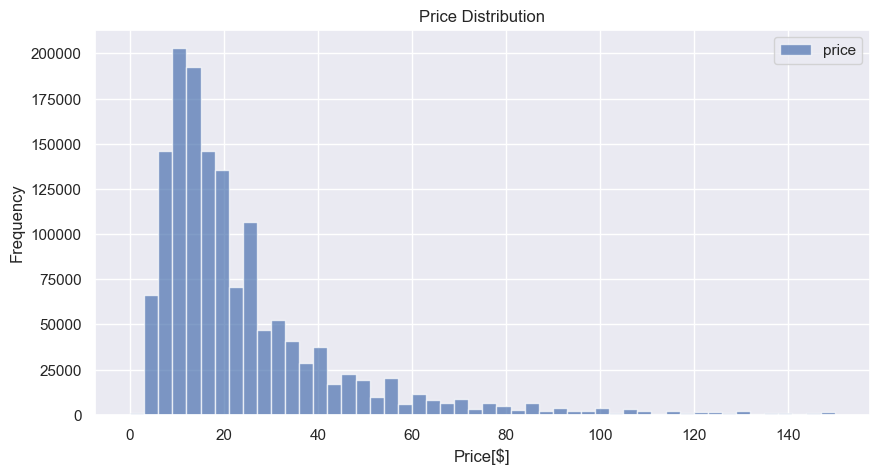

In [39]:
#priceをヒストグラムで表示
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(figsize=(10, 5))
plt.hist(train.price, bins=50, range=[0, 150], alpha=0.7, color='b', label='price')
plt.title('Price Distribution')
plt.xlabel('Price[$]') 
plt.ylabel('Frequency')
plt.legend()

#### 分布が左に偏っているため対数変換して、正規分布にする
分析に使うモデルは出力値の誤差が正規分布に従うと仮定しているので、対数変換してpriceを正規分布に近似させる。

対数変換は、スケール変換と異なり、分布も変化する。これはデータの値が大きいときはその範囲が縮小され、小さいときは拡大されるからである。

つまり、裾の長い分布の範囲を狭めて山型にしたり、極度に集中している分布を押しつぶして裾の長い分布に近づけることが出来る。(今回は後者)

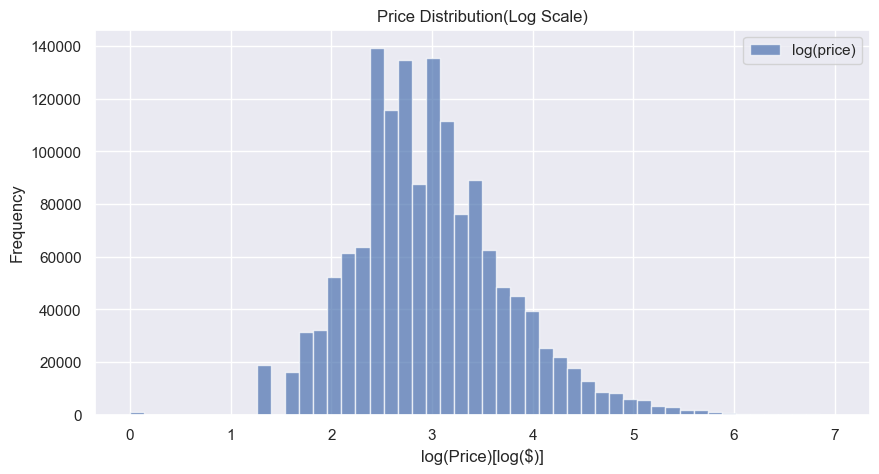

In [40]:
#priceを対数変換してヒストグラムで表示
plt.figure(figsize=(10, 5))
plt.hist(np.log1p(train.price), bins=50, range=[0, 7], alpha=0.7, color='b', label='price')
plt.title('Price Distribution(Log Scale)')
plt.xlabel('log(Price)[log($)]')
plt.ylabel('Frequency')
plt.legend(['log(price)'])

#### Shipping

商品の送料の半分以上（55%）は売り手が負担

In [41]:
#shippingの割合を表示 1が販売者負担、0が購入者負担
train.shipping.value_counts() / len(train)

shipping
0    0.552726
1    0.447274
Name: count, dtype: float64

追加の送料分があるから、送料別(買い手負担、赤色のグラフ)の方が安い

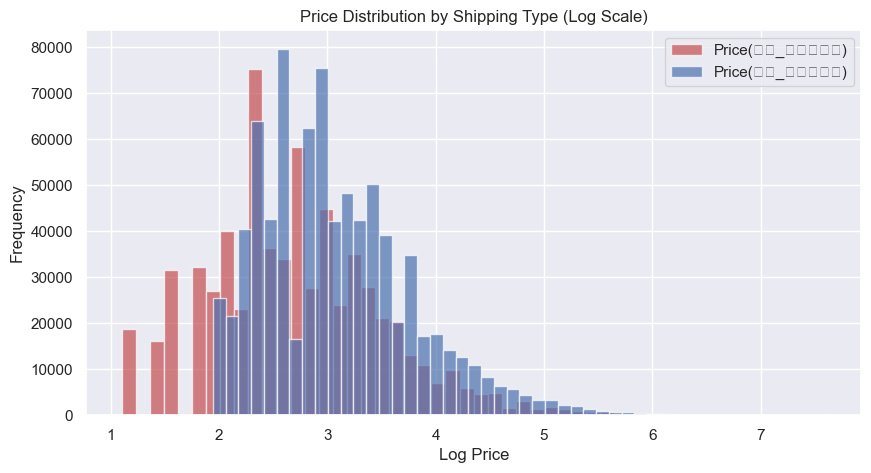

In [42]:
#shippingが売り手負担かどうかでpriceがどう変わるかを確認
plt.figure(figsize=(10, 5))

shipping_fee_by_seller = train.loc[train.shipping==1, 'price']
shipping_fee_by_buyer = train.loc[train.shipping==0, 'price']

# 価格データを対数変換し、0を除外
log_shipping_fee_by_seller = np.log(shipping_fee_by_seller[shipping_fee_by_seller > 0])
log_shipping_fee_by_buyer = np.log(shipping_fee_by_buyer[shipping_fee_by_buyer > 0])

# import japanize_matplotlib # 日本語化
plt.hist(log_shipping_fee_by_seller, bins=50, alpha=0.7, color='r', label='Price(送料_買い手負担)')
plt.hist(log_shipping_fee_by_buyer, bins=50, alpha=0.7, color='b', label='Price(送料_売り手負担)')

plt.title('Price Distribution by Shipping Type (Log Scale)')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.legend()

#### category_name

女性用の服、美容品が多い

In [43]:
#Top 10のカテゴリを表示 
train.category_name.value_counts()[:10] #[:10]で上位10件を表示 [10:]で下位10件を表示

category_name
Women/Athletic Apparel/Pants, Tights, Leggings                 60177
Women/Tops & Blouses/T-Shirts                                  46380
Beauty/Makeup/Face                                             34335
Beauty/Makeup/Lips                                             29910
Electronics/Video Games & Consoles/Games                       26557
Beauty/Makeup/Eyes                                             25215
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    24676
Women/Underwear/Bras                                           21274
Women/Tops & Blouses/Blouse                                    20284
Women/Tops & Blouses/Tank, Cami                                20284
Name: count, dtype: int64

#### -------------------- 前処理開始 --------------------

#### ----------------- price -----------------

#### 3ドル未満のレコードを削除 追加：2000ドル以上の行も削除
1,482,535→1,481,661点となり、874の商品が削除された 2000ドル以上の9点も削除

In [44]:
train = train.drop(train[(train.price < 3.0)].index)
train = train.drop(train[(train.price > 2000.0)].index)
print(train.shape)
print(train["price"].min()) #priceの最小値
print(train["price"].max()) #priceの最大値

(1481658, 8)
3.0
2000.0


#### ----------------- category_name -----------------

#### general_category, sub_category1, sub_category2 に3等分する

In [45]:
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label") #categoryがない場合はNo Labelを返す

train['general_cat'], train['sub_cat1'], train['sub_cat2'] = zip(*train['category_name'].apply(lambda x: split_cat(x))) #zip(*df)で転置
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


#### testデータも同様に3等分

In [46]:
test['general_cat'], test['sub_cat1'], test['sub_cat2'] = zip(*test['category_name'].apply(lambda x: split_cat(x)))

#### 7つのメインカテゴリがあり、女性向けの商品が多い

Text(0, 0.5, 'general category')

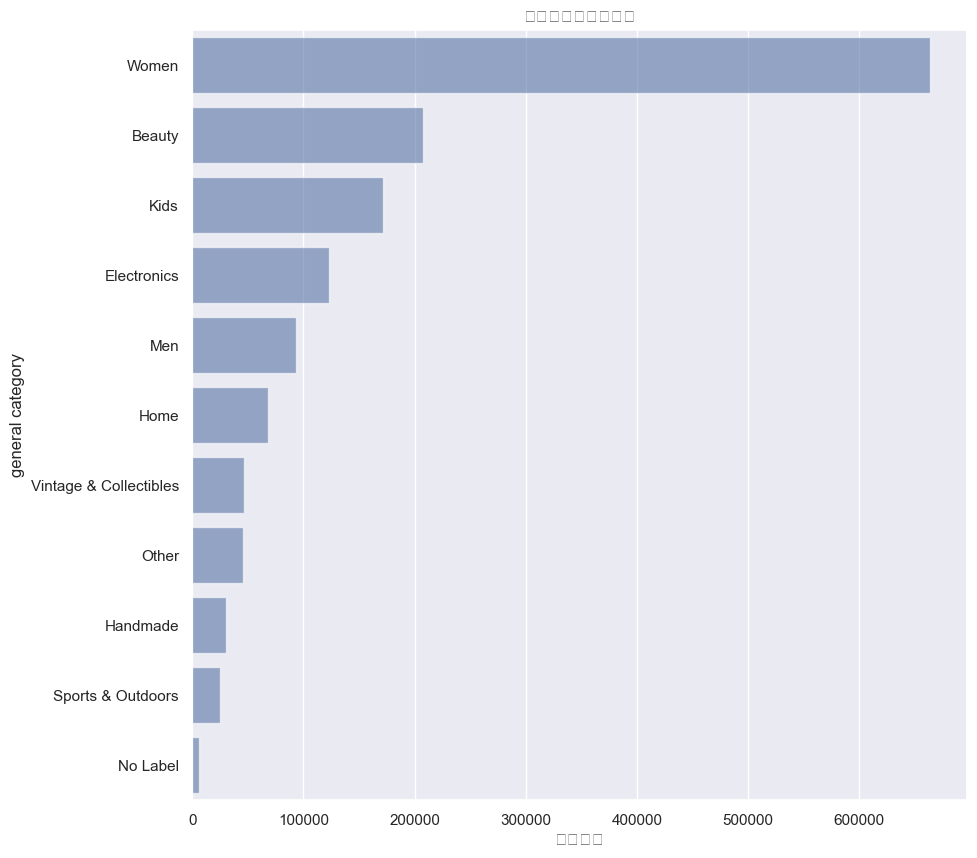

In [47]:
x_general = train['general_cat'].value_counts().index.values.astype('str') #カテゴリ名
y_general = train['general_cat'].value_counts().values #カテゴリの出現回数
pct = [("%.2f"%(v*100))+"%"for v in (y_general/len(train))] #パーセンテージ

plt.figure(figsize=(10,10))
sns.barplot(x=y_general, y=x_general, alpha=0.6)
plt.title("出品カテゴリの分布")
plt.xlabel("出現回数")
plt.ylabel("general category")

#### サブカテゴリのうち、Apparel, Make, Topsなどが多い

Text(0, 0.5, 'sub category')

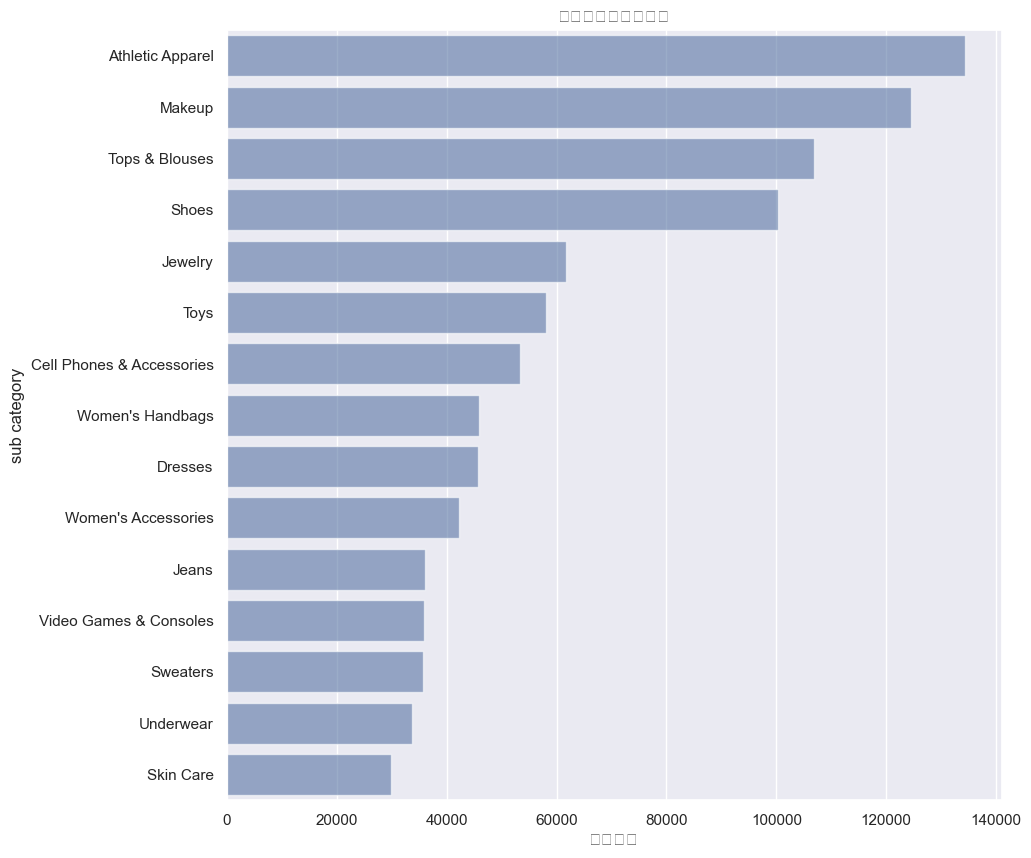

In [48]:
x_sub = train['sub_cat1'].value_counts().index.values.astype('str')[:15]
y_sub = train['sub_cat1'].value_counts().values[:15]
pct = [("%.2f"%(v*100))+"%"for v in (y_sub/len(train))][:15]

plt.figure(figsize=(10,10))
sns.barplot(x=y_sub, y=x_sub, alpha=0.6)
plt.title("出品カテゴリの分布")
plt.xlabel("出現回数")
plt.ylabel("sub category")

object(文字列)のままだと学習ができないため、カテゴリ変数にする

In [49]:
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
general_cat           object
sub_cat1              object
sub_cat2              object
dtype: object

In [50]:
#general_cat, sub_cat1, sub_cat2をカテゴリ変数に変換
train['general_cat'] = train['general_cat'].astype('category')
train['sub_cat1'] = train['sub_cat1'].astype('category')
train['sub_cat2'] = train['sub_cat2'].astype('category')
train.dtypes

train_id                int64
name                   object
item_condition_id       int64
category_name          object
brand_name             object
price                 float64
shipping                int64
item_description       object
general_cat          category
sub_cat1             category
sub_cat2             category
dtype: object

#### ----------------- brand_name -----------------
#### 欠損値処理

1. ブランド名の欠損値(NaN)を"missing"に置き換える
2. このままだと欠損値であることに変わりないので、"name(商品名)"が、ブランド名のリストに含まれる場合、ブランド名の"missing"を"name(商品名)"に書き換える

これにより、ブランド名(brand_name)が記載されていない商品でも、商品名(name)からブランド名を取得し、代入することができる

train：1,482,535個の商品

test：693,359個の商品

train_test_combine：2,175,894個の商品

In [51]:
#train,testを縦方向に結合し、まとめて前処理できるようにする
train_test_combine = pd.concat([train,test]) #axis=0で行、axis=1で列に結合 デフォルトはaxis=0
print(train_test_combine.shape)
train_test_combine.head()

(2175017, 12)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2,test_id
0,0.0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,NaN
1,1.0,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,NaN
2,2.0,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,NaN
3,3.0,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,NaN
4,4.0,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,NaN


#### 重複なしのブランドリストを作り、欠損値を"missing"に置き換える

In [52]:
#brand_nameの重複なしのリストを作成
brand_name_list = set(train_test_combine["brand_name"].values) #set()で重複を削除

# 'brand_name'の欠損値NaNを'missing'に置き換える
train['brand_name'].fillna(value='missing', inplace=True)
test['brand_name'].fillna(value='missing', inplace=True)

# 訓練データの'brand_name'が'missing'に一致するレコード数を取得
train_premissing = len(train.loc[train['brand_name'] == 'missing'])
# テストデータの'brand_name'が'missing'に一致するレコード数を取得
test_premissing = len(test.loc[test['brand_name'] == 'missing'])

train_premissing, test_premissing #欠損値の数

(632336, 295525)

brand_name(trainデータ): 63万点のうち、13.7万点がブランド名を表すデータに書き換えられた

brand_name(testデータ): 29万点のうち、6.4万点がブランド名を表すデータに書き換えられた

In [53]:
%%time
def brandfinder(line):
    brand = line[0] # 第1要素はブランド名
    name = line[1]  # 第2要素は商品名
    namesplit = name.split(' ') # 商品名をスペースで切り分ける
    
    if brand == 'missing':  # ブランド名が'missing'の場合
        for x in namesplit: # 商品名から切り分けた単語を取り出す
            if x in brand_name_list: # 単語がブランドリストに存在すればブランド名を返す              
                return name # 単語がブランドリストに一致したら商品名を返す
    if name in brand_name_list:  # 商品名がブランドリストに存在すれば商品名を返す
        return name
    
    return brand            # どれにも一致しなければブランド名を返す

# ブランド名の付替えを実施
train['brand_name'] = train[['brand_name','name']].apply(brandfinder, axis = 1) #axis=1で行方向
test['brand_name'] = test[['brand_name','name']].apply(brandfinder, axis = 1)

# 書き換えられた'missing'の数を取得
train_found = train_premissing-len(train.loc[train['brand_name'] == 'missing'])
test_found = test_premissing-len(test.loc[test['brand_name'] == 'missing'])

print(train_premissing) # 書き換える前の'missing'の数
print(train_found)      # 書き換えられた'missing'の数
print(test_premissing)  # 書き換える前の'missing'の数
print(test_found)       # 書き換えられた'missing'の数

632336
137342
295525
64154
CPU times: user 23.4 s, sys: 537 ms, total: 24 s
Wall time: 24.2 s


表の1番目の"brand_name"がmissing → MLB Cincinnatiとなり、missingが"name(商品名)"に書き換えられた

In [54]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,MLB Cincinnati Reds T Shirt Size XL,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


#### ----------------- エンコード(文字列→数値データ) -----------------

機械学習ではカテゴリ変数(name, category_name, brand_name, item_description)を文字列ではなく、数値型に変換する必要がある

#### name, category_name, brand_name, item_descriptionの欠損値(NaN)を"missing"で埋める

In [55]:
#fillnaで欠損値を埋める
train_test_combine['name'].fillna(value='missing', inplace=True)
train_test_combine['category_name'].fillna(value='missing', inplace=True)
train_test_combine['general_cat'].fillna(value='missing', inplace=True)
train_test_combine['sub_cat1'].fillna(value='missing', inplace=True)
train_test_combine['sub_cat2'].fillna(value='missing', inplace=True)
train_test_combine['brand_name'].fillna(value='missing', inplace=True)
train_test_combine['item_description'].fillna(value='missing', inplace=True)

#### name, item_descriptionはトークンに分解してからエンコードするため、一旦放置

下の表でわかるように文字列がすべて数値データに変換された

test_idがNaNだけど、気にしなくていいや

In [56]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

#カテゴリ変数を数値に変換
# train_test_combine['name'] = le.fit_transform(train_test_combine['name'])
train_test_combine['category_name'] = le.fit_transform(train_test_combine['category_name'])
train_test_combine['general_cat'] = le.fit_transform(train_test_combine['general_cat'])
train_test_combine['sub_cat1'] = le.fit_transform(train_test_combine['sub_cat1'])
train_test_combine['sub_cat2'] = le.fit_transform(train_test_combine['sub_cat2'])
train_test_combine['brand_name'] = le.fit_transform(train_test_combine['brand_name'])
# train_test_combine['item_description'] = le.fit_transform(train_test_combine['item_description'])

display(train_test_combine.head())

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2,test_id
0,0.0,MLB Cincinnati Reds T Shirt Size XL,3,829,5263,10.0,1,No description yet,5,103,774,NaN
1,1.0,Razer BlackWidow Chroma Keyboard,3,86,3887,52.0,0,This keyboard is in great condition and works ...,1,30,215,NaN
2,2.0,AVA-VIV Blouse,1,1277,4586,10.0,1,Adorable top with a hint of lace and a key hol...,10,104,97,NaN
3,3.0,Leather Horse Statues,1,503,5263,35.0,1,New with tags. Leather horses. Retail for [rm]...,3,55,410,NaN
4,4.0,24K GOLD plated rose,1,1204,5263,44.0,0,Complete with certificate of authenticity,10,58,542,NaN


#### name, item_descriptionをエンコード(自然言語処理)
name, item_descriptionは複数の単語で構成されるので、単純なエンコード(数値変換)ではなく、KerasのTokenizerクラスを使ってエンコード

Tokenizerとは

* 英文のテキストデータをトークン(最小単位)に分解する
* 各トークンに通し番号(インデックス)を割り振ることで実数ベクトルに変換する

分かりやすいzenn記事：https://zenn.dev/robes/articles/b6708032855a9c

In [57]:
%%time
from tensorflow.keras.preprocessing.text import Tokenizer

print("Transforming text data to sequences...")
raw_text = np.hstack(
    [train_test_combine.item_description.str.lower(), # 説明文
     train_test_combine.name.str.lower()]           # 商品名
)
print('sequences shape', raw_text.shape)

# 説明文、商品名、カテゴリ名を連結した配列でTokenizerを作る
print("   Fitting tokenizer...")
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)

# Tokenizerで説明文、商品名をそれぞれラベルエンコードする
print("   Transforming text to sequences...")
train_test_combine['seq_item_description'] = tok_raw.texts_to_sequences(train_test_combine.item_description.str.lower())
train_test_combine['seq_name'] = tok_raw.texts_to_sequences(train_test_combine.name.str.lower())

del tok_raw #delは変数を削除する

print(train_test_combine.seq_item_description.head())
print(train_test_combine.seq_name.head())

Transforming text data to sequences...
sequences shape (4350034,)
   Fitting tokenizer...
   Transforming text to sequences...
0                                         [12, 68, 79]
1    [29, 2666, 10, 7, 38, 17, 1, 206, 51, 19, 1099...
2    [597, 60, 9, 4, 5351, 11, 192, 1, 4, 900, 1299...
3    [5, 9, 61, 178, 6621, 229, 3, 21, 166, 1086, 2...
4                             [801, 9, 7022, 11, 2013]
Name: seq_item_description, dtype: object
0    [3882, 8986, 6977, 208, 84, 6, 155]
1            [11402, 27913, 17350, 2666]
2                     [7811, 10858, 666]
3                     [178, 2603, 14008]
4                 [4962, 103, 1032, 280]
Name: seq_name, dtype: object
CPU times: user 1min 9s, sys: 2.08 s, total: 1min 11s
Wall time: 1min 13s


#### 0でパディング(埋める)して配列の長さを揃える

自然言語処理の学習における入力データは固定長化する必要がある

参考サイト；https://moneyforward-dev.jp/entry/2021/10/05/transformers-tokenizer/

In [58]:
%%time
from keras.preprocessing.sequence import pad_sequences
print(pad_sequences(train_test_combine.seq_item_description, maxlen=80),'\n') # 商品説明
print(pad_sequences(train_test_combine.seq_name, maxlen=10))                  # 商品名

[[    0     0     0 ...    12    68    79]
 [    0     0     0 ...    14    49   996]
 [    0     0     0 ...   175     7    59]
 ...
 [    0     0     0 ...    20 63502    88]
 [    0     0     0 ...     4   369    71]
 [    0     0     0 ...     4   593   635]] 

[[    0     0     0 ...    84     6   155]
 [    0     0     0 ... 27913 17350  2666]
 [    0     0     0 ...  7811 10858   666]
 ...
 [    0     0     0 ...   401  1559    88]
 [    0     0     0 ...   325   281  2230]
 [    0     0     0 ...   892   725    69]]
CPU times: user 4.39 s, sys: 181 ms, total: 4.57 s
Wall time: 4.83 s


In [59]:
train_test_combine.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2,test_id,seq_item_description,seq_name
0,0.0,MLB Cincinnati Reds T Shirt Size XL,3,829,5263,10.0,1,No description yet,5,103,774,NaN,"[12, 68, 79]","[3882, 8986, 6977, 208, 84, 6, 155]"
1,1.0,Razer BlackWidow Chroma Keyboard,3,86,3887,52.0,0,This keyboard is in great condition and works ...,1,30,215,NaN,"[29, 2666, 10, 7, 38, 17, 1, 206, 51, 19, 1099...","[11402, 27913, 17350, 2666]"
2,2.0,AVA-VIV Blouse,1,1277,4586,10.0,1,Adorable top with a hint of lace and a key hol...,10,104,97,NaN,"[597, 60, 9, 4, 5351, 11, 192, 1, 4, 900, 1299...","[7811, 10858, 666]"
3,3.0,Leather Horse Statues,1,503,5263,35.0,1,New with tags. Leather horses. Retail for [rm]...,3,55,410,NaN,"[5, 9, 61, 178, 6621, 229, 3, 21, 166, 1086, 2...","[178, 2603, 14008]"
4,4.0,24K GOLD plated rose,1,1204,5263,44.0,0,Complete with certificate of authenticity,10,58,542,NaN,"[801, 9, 7022, 11, 2013]","[4962, 103, 1032, 280]"


#### name, item_descriptionの単語数をカウントした列を追加

単語数が多いと価格も高い？

In [60]:
%%time
def wordCount(text):
    """
    Parameters:
      text(str): 商品名、商品の説明文
    """
    try:
        if text == 'No description yet':
            return 0  # 商品名や説明が'No description yet'の場合は0を返す
        else:
            text = text.lower()                  # すべて小文字にする
            words = [w for w in text.split(" ")] # スペースで切り分ける
            return len(words)                    # 単語の数を返す
    except: 
        return 0

# 'name'の各フィールドの単語数を'name_len'に登録
train_test_combine['name_len'] = train_test_combine['name'].apply(lambda x: wordCount(x))
# 'item_description'の各フィールドの単語数を'desc_len'に登録
train_test_combine['desc_len'] = train_test_combine['item_description'].apply(lambda x: wordCount(x))

CPU times: user 4.17 s, sys: 174 ms, total: 4.35 s
Wall time: 4.39 s


#### name, item_descriptionが文字列なのでカテゴリ変数に変換

In [61]:
# 文字列(object)カテゴリー変数に変換
train_test_combine['name'] = train_test_combine['name'].astype('category')
train_test_combine['item_description'] = train_test_combine['item_description'].astype('category')

#### seq_item_description, seq_nameはリスト型なので、一旦文字列に変換してからカテゴリ変数にする

In [62]:
# リストを文字列に変換してからカテゴリー変数に変換
train_test_combine['seq_item_description'] = train_test_combine['seq_item_description'].apply(lambda x: str(x)).astype('category')
train_test_combine['seq_name'] = train_test_combine['seq_name'].apply(lambda x: str(x)).astype('category')

In [63]:
print(train_test_combine.shape)
print(train_test_combine.info())
display(train_test_combine.head())

(2175017, 16)
<class 'pandas.core.frame.DataFrame'>
Index: 2175017 entries, 0 to 693358
Data columns (total 16 columns):
 #   Column                Dtype   
---  ------                -----   
 0   train_id              float64 
 1   name                  category
 2   item_condition_id     int64   
 3   category_name         int64   
 4   brand_name            int64   
 5   price                 float64 
 6   shipping              int64   
 7   item_description      category
 8   general_cat           int64   
 9   sub_cat1              int64   
 10  sub_cat2              int64   
 11  test_id               float64 
 12  seq_item_description  category
 13  seq_name              category
 14  name_len              int64   
 15  desc_len              int64   
dtypes: category(4), float64(3), int64(9)
memory usage: 528.2 MB
None


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2,test_id,seq_item_description,seq_name,name_len,desc_len
0,0.0,MLB Cincinnati Reds T Shirt Size XL,3,829,5263,10.0,1,No description yet,5,103,774,NaN,"[12, 68, 79]","[3882, 8986, 6977, 208, 84, 6, 155]",7,0
1,1.0,Razer BlackWidow Chroma Keyboard,3,86,3887,52.0,0,This keyboard is in great condition and works ...,1,30,215,NaN,"[29, 2666, 10, 7, 38, 17, 1, 206, 51, 19, 1099...","[11402, 27913, 17350, 2666]",4,36
2,2.0,AVA-VIV Blouse,1,1277,4586,10.0,1,Adorable top with a hint of lace and a key hol...,10,104,97,NaN,"[597, 60, 9, 4, 5351, 11, 192, 1, 4, 900, 1299...","[7811, 10858, 666]",2,29
3,3.0,Leather Horse Statues,1,503,5263,35.0,1,New with tags. Leather horses. Retail for [rm]...,3,55,410,NaN,"[5, 9, 61, 178, 6621, 229, 3, 21, 166, 1086, 2...","[178, 2603, 14008]",3,32
4,4.0,24K GOLD plated rose,1,1204,5263,44.0,0,Complete with certificate of authenticity,10,58,542,NaN,"[801, 9, 7022, 11, 2013]","[4962, 103, 1032, 280]",4,5


#### priceを対数変換して正規化

In [64]:
# 訓練データの'price'を対数変換する
train['price'] = np.log1p(train['price']) # <---

#### 前処理後の結合したデータ(train_test_combine)を再びtrain,testデータに分割する

train：1,482,535点

test：693,359点

In [65]:
#train_test_combineからtrainとtestに分割
train = train_test_combine[:len(train)]
train = train.drop(columns='test_id') # <---
train['train_id'] = train['train_id'].astype(int)

test = train_test_combine[len(train):]
test = test.drop(columns='train_id') # <---
test['test_id'] = test['test_id'].astype(int)
# 'test_id'列を先頭に移動
test.insert(0, 'test_id', test.pop('test_id'))

#### カテゴリ変数(category)だとモデルの学習ができなかったので、数値(int)に変換

In [66]:
%%time
# name, item_description, seq_item_description, seq_name, name_len, desc_lenを数値に変換
train['name'] = le.fit_transform(train['name'])
train['item_description'] = le.fit_transform(train['item_description'])
test['name'] = le.fit_transform(test['name'])
test['item_description'] = le.fit_transform(test['item_description'])
train['seq_item_description'] = le.fit_transform(train['seq_item_description'])
train['seq_name'] = le.fit_transform(train['seq_name'])
train['name_len'] = le.fit_transform(train['name_len'])
train['desc_len'] = le.fit_transform(train['desc_len'])

CPU times: user 12.7 s, sys: 500 ms, total: 13.2 s
Wall time: 13.3 s


In [67]:
print(train.shape)
print(train.info())
display(train.head())

(1481658, 15)
<class 'pandas.core.frame.DataFrame'>
Index: 1481658 entries, 0 to 1482534
Data columns (total 15 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   train_id              1481658 non-null  int64  
 1   name                  1481658 non-null  int64  
 2   item_condition_id     1481658 non-null  int64  
 3   category_name         1481658 non-null  int64  
 4   brand_name            1481658 non-null  int64  
 5   price                 1481658 non-null  float64
 6   shipping              1481658 non-null  int64  
 7   item_description      1481658 non-null  int64  
 8   general_cat           1481658 non-null  int64  
 9   sub_cat1              1481658 non-null  int64  
 10  sub_cat2              1481658 non-null  int64  
 11  seq_item_description  1481658 non-null  int64  
 12  seq_name              1481658 non-null  int64  
 13  name_len              1481658 non-null  int64  
 14  desc_len              148

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2,seq_item_description,seq_name,name_len,desc_len
0,0,640447,3,829,5263,10.0,1,806113,5,103,774,77041,679112,6,0
1,1,903433,3,86,3887,52.0,0,1090218,1,30,215,572086,66776,3,36
2,2,91487,1,1277,4586,10.0,1,115208,10,104,97,1003481,1009527,1,29
3,3,560822,1,503,5263,35.0,1,781822,3,55,410,907901,293663,2,32
4,4,45459,1,1204,5263,44.0,0,366430,10,58,542,1155041,782360,3,5


In [68]:
print(test.shape)
print(test.info())
display(test.head())

(693359, 15)
<class 'pandas.core.frame.DataFrame'>
Index: 693359 entries, 0 to 693358
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   test_id               693359 non-null  int64   
 1   name                  693359 non-null  int64   
 2   item_condition_id     693359 non-null  int64   
 3   category_name         693359 non-null  int64   
 4   brand_name            693359 non-null  int64   
 5   price                 0 non-null       float64 
 6   shipping              693359 non-null  int64   
 7   item_description      693359 non-null  int64   
 8   general_cat           693359 non-null  int64   
 9   sub_cat1              693359 non-null  int64   
 10  sub_cat2              693359 non-null  int64   
 11  seq_item_description  693359 non-null  category
 12  seq_name              693359 non-null  category
 13  name_len              693359 non-null  int64   
 14  desc_len              693359

,test_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2,seq_item_description,seq_name,name_len,desc_len
0,0,110376,1,1205,5263,NaN,1,457436,10,58,667,"[6, 64]","[1789, 3475, 15, 5555, 51, 4, 266, 263]",8,2
1,1,21757,1,899,5263,NaN,1,31753,7,72,701,"[439, 802, 5, 64, 34, 9038, 5187, 616, 1024, 7...","[439, 802, 5, 64, 34, 9038, 5187, 616, 1024]",7,38
2,2,140281,1,1000,1093,NaN,1,125968,9,7,382,"[16, 5, 315, 101, 201, 3, 21, 107, 4, 315, 3689]","[315, 101]",2,11
3,3,186403,2,1256,5263,NaN,0,11516,10,97,166,"[281, 2230, 37, 30, 577, 1, 93, 3, 350, 1844]","[281, 2230]",2,10
4,4,277503,3,860,5263,NaN,1,431600,7,14,662,"[98827, 473, 286, 2, 1504, 11, 4, 1093, 46, 10...","[473, 286, 5470]",3,29


In [69]:
# 欠損値が残っていないか確認
print(train.isnull().sum())
print(test.isnull().sum())

train_id                0
name                    0
item_condition_id       0
category_name           0
brand_name              0
price                   0
shipping                0
item_description        0
general_cat             0
sub_cat1                0
sub_cat2                0
seq_item_description    0
seq_name                0
name_len                0
desc_len                0
dtype: int64
test_id                      0
name                         0
item_condition_id            0
category_name                0
brand_name                   0
price                   693359
shipping                     0
item_description             0
general_cat                  0
sub_cat1                     0
sub_cat2                     0
seq_item_description         0
seq_name                     0
name_len                     0
desc_len                     0
dtype: int64


#### 前処理後データの保存

In [70]:
train.to_csv('train_preprocessed_ridge.csv', index=False)
test.to_csv('test_preprocessed_ridge.csv', index=False)

#### -------------------- 前処理終了 --------------------

## Optunaでハイパーパラメータチューニング
時間削減のため、前処理後のcsvデータを使う

#### モデルの作成と学習

#### 説明変数と目的変数の数値を分ける

In [71]:
import pandas as pd
import numpy as np
#前処理後のcsvファイルを読み込む
train = pd.read_csv('train_preprocessed_ridge.csv')
test = pd.read_csv('test_preprocessed_ridge.csv')

X = train.loc[:, 'name':].drop(columns='price') # <---
y = train['price'] # <---
print('X:', X.shape)
display(X.head())
print('y:', y.shape)
print(y.head())

X: (1481658, 13)


,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,sub_cat1,sub_cat2,seq_item_description,seq_name,name_len,desc_len
0,640447,3,829,5263,1,806113,5,103,774,77041,679112,6,0
1,903433,3,86,3887,0,1090218,1,30,215,572086,66776,3,36
2,91487,1,1277,4586,1,115208,10,104,97,1003481,1009527,1,29
3,560822,1,503,5263,1,781822,3,55,410,907901,293663,2,32
4,45459,1,1204,5263,0,366430,10,58,542,1155041,782360,3,5


y: (1481658,)
0    10.0
1    52.0
2    10.0
3    35.0
4    44.0
Name: price, dtype: float64


#### Xとyのうち、7割を訓練用(train)、3割を検証用(test)に分割する

本に載ってた99:1は極端すぎる、一般的には7:3

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [73]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1037160, 13)
(1037160,)
(444498, 13)
(444498,)


## Optuna(19分3秒かかった)

Ridge回帰は、L2正則化を行う線形回帰モデルで、正則化の強さを調整するalphaパラメータがあります。このalphaを最適化するためにOptunaを使用

Ridgeの主要なパラメータ
* alpha（正則化強度）

説明: L2正則化の強度を制御します。値が大きいほど、正則化が強くなり、モデルの複雑さが抑制されます。
型: float
デフォルト: 1.0

* fit_intercept
説明: 切片（バイアス）を計算するかどうかを指定します。
型: bool
デフォルト: True
備考: データがすでに中心化されている場合はFalseに設定することもできます。

* normalize
説明: データを正規化（標準化）するかどうかを指定します。fit_intercept=Falseのときは無視されます。
型: bool
デフォルト: False
備考: このパラメータはfit_intercept=Trueの場合のみ意味があります。なお、StandardScalerを使って事前にデータを正規化している場合、このパラメータは使用しません。

* max_iter
説明: ソルバーが収束するまでの最大反復回数を指定します。
型: int
デフォルト: None（無制限）
備考: 特に大きなデータセットの場合、max_iterを適切に設定することが重要です。

* tol
説明: 収束のための許容誤差。目標の収束条件を満たすために、損失関数がこの値より小さくなった場合にソルバーは停止します。
型: float
デフォルト: 1e-3

* solver
説明: 線形回帰の計算に使用するソルバーを指定します。選択肢は以下の通りです。
  auto: データに基づいて自動的にソルバーを選択します。

  svd: 特異値分解（SVD）を使用します。データが奇異行列の場合に適しています。

  cholesky: Cholesky分解を使用します。

  lsqr: 最小二乗解を反復的に求める方法を使用します。

  sag: 大規模データセット向けの確率的平均勾配降下法（SAG）を使用します。

  saga: sagの改良版で、L1正則化を含む場合に有効です。
  
  型: str
  デフォルト: auto
  備考: データの特性に応じて最適なソルバーを選択することが重要です。


* random_state
説明: solver='sag'やsagaを使う場合に、乱数生成のシードを固定します。
型: int, RandomState instance, None
デフォルト: None
備考: 再現性を確保するために指定することが推奨されます。

In [74]:
!pip install optuna

import optuna
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error

# RMSLE関数の定義
def rmsle(y_true, y_pred):
    # クリップして無限大や非常に大きな値を避ける
    y_true_clipped = np.clip(y_true, 0, np.log(np.finfo(np.float64).max))
    y_pred_clipped = np.clip(y_pred, 0, np.log(np.finfo(np.float64).max))
    
    return np.sqrt(mean_squared_log_error(y_true_clipped, y_pred_clipped))


def objective(trial):
    # ハイパーパラメータの設定
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e5) #loguniformは対数スケールで探索
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    solver = trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga'])
    random_state = trial.suggest_int('random_state', 0, 1000)
    max_iter = trial.suggest_int('max_iter', 100, 1000)# 反復回数の上限。モデルが収束するまでの計算時間を制御

    # モデルの定義
    ridge = Ridge(alpha=alpha, fit_intercept=fit_intercept, solver=solver, random_state=random_state, max_iter=max_iter)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    return rmsle(y_test, y_pred)

study = optuna.create_study(direction='minimize')
# 最適化の実行
study.optimize(objective, n_trials=50)


print(study.best_params)#最適なパラメータ


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


[I 2024-08-27 22:49:58,735] A new study created in memory with name: no-name-6e38af79-de85-45b2-aeee-4f132689fc70
[I 2024-08-27 22:51:28,433] Trial 0 finished with value: 0.8117194930073456 and parameters: {'alpha': 1.3026841605986434, 'fit_intercept': False, 'solver': 'sag', 'random_state': 181, 'max_iter': 387}. Best is trial 0 with value: 0.8117194930073456.
[I 2024-08-27 22:51:28,713] Trial 1 finished with value: 0.8070962495433481 and parameters: {'alpha': 0.5692931700173869, 'fit_intercept': True, 'solver': 'lsqr', 'random_state': 365, 'max_iter': 829}. Best is trial 1 with value: 0.8070962495433481.
[I 2024-08-27 22:55:18,354] Trial 2 finished with value: 0.8094894665886163 and parameters: {'alpha': 0.00042754802296767586, 'fit_intercept': False, 'solver': 'sag', 'random_state': 635, 'max_iter': 994}. Best is trial 1 with value: 0.8070962495433481.
[I 2024-08-27 22:55:18,460] Trial 3 finished with value: 0.7811440738687772 and parameters: {'alpha': 0.014222554446051706, 'fit_int

{'alpha': 1.0086764125393944e-05, 'fit_intercept': True, 'solver': 'auto', 'random_state': 990, 'max_iter': 135}


In [75]:
print(study.best_params)#最適なパラメータ

{'alpha': 1.0086764125393944e-05, 'fit_intercept': True, 'solver': 'auto', 'random_state': 990, 'max_iter': 135}


{'alpha': 448.3939318992722, 'fit_intercept': True, 'solver': 'cholesky', 'random_state': 422, 'max_iter': 590}
{alpha': 0.026390523652282456, 'fit_intercept': True, 'solver': 'cholesky', 'random_state': 739, 'max_iter': 404}

#### モデルの学習

In [76]:
%%time
from sklearn.linear_model import Ridge

# 最適なパラメータでモデルを再作成
best_params = study.best_params
best_alpha = best_params['alpha']
best_fit_intercept = best_params['fit_intercept']
best_solver = best_params['solver']
best_random_state = best_params['random_state']
best_max_iter = best_params['max_iter']
ridge = Ridge(alpha=best_alpha, fit_intercept=best_fit_intercept, solver=best_solver, random_state=best_random_state, max_iter=best_max_iter)
ridge.fit(X_train, y_train)

CPU times: user 368 ms, sys: 370 ms, total: 738 ms
Wall time: 118 ms


Ridge(alpha=1.0086764125393944e-05, max_iter=135, random_state=990)

#### モデルの特徴重要度（係数の絶対値）

In [77]:
ser_fi = pd.Series(np.abs(ridge.coef_), index=X_train.columns)
print(ser_fi.sort_values(ascending=False))

shipping                7.706247
general_cat             2.246651
item_condition_id       1.113012
name_len                0.643879
desc_len                0.079005
sub_cat1                0.016983
category_name           0.015697
brand_name              0.002625
sub_cat2                0.001428
item_description        0.000003
name                    0.000002
seq_name                0.000002
seq_item_description    0.000002
dtype: float64


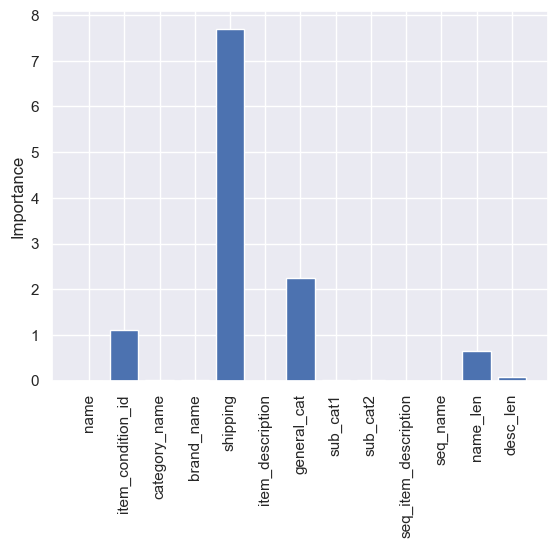

In [78]:
import matplotlib.pyplot as plt
plt.bar(X_train.columns, np.abs(ridge.coef_))
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

#### 訓練データに対する予測

In [79]:
y_train_pred = ridge.predict(X_train)

In [80]:
y_min = np.append(y_train_pred, y_train).min()
y_max = np.append(y_train_pred, y_train).max()
y_margin = (y_max - y_min) * 0.1
y_min -= y_margin
y_max += y_margin

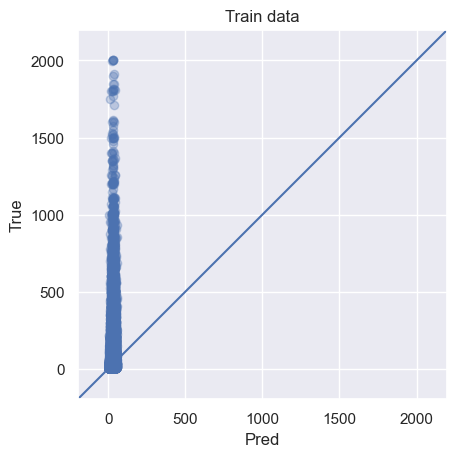

In [81]:
plt.scatter(y_train_pred, y_train, alpha=0.3)
plt.plot([y_min,y_max], [y_min,y_max])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(y_min, y_max)
plt.ylim(y_min, y_max)
plt.title('Train data')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

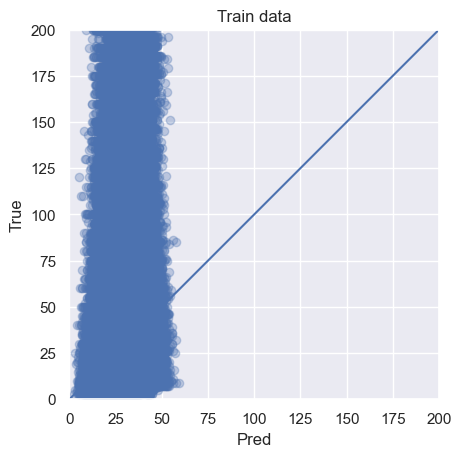

In [82]:
plt.scatter(y_train_pred, y_train, alpha=0.3)
plt.plot([y_min,y_max], [y_min,y_max])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 200) # <---
plt.ylim(0, 200) # <---
plt.title('Train data')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

In [83]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_train, y_train_pred)
print('MSE, RMSE for train data:', mse, np.sqrt(mse))

MSE, RMSE for train data: 1442.5482241013983 37.980892881834656


パラメータ調整前： 1460.2566359716102 38.213304436696

In [84]:
from sklearn.metrics import mean_squared_log_error

# RMSLE関数の定義
def rmsle(y_true, y_pred):
    # クリップして無限大や非常に大きな値を避ける
    y_true_clipped = np.clip(y_true, 0, np.log(np.finfo(np.float64).max))
    y_pred_clipped = np.clip(y_pred, 0, np.log(np.finfo(np.float64).max))
    
    return np.sqrt(mean_squared_log_error(y_true_clipped, y_pred_clipped))

In [85]:
# def rmsle(y_true, y_pred):  
#     return np.sqrt(mean_squared_log_error(y_true, y_pred))

# メモ:
# この関数を使用すると、
# ValueError: Input contains infinity or a value too large for dtype('float64').
# というエラーが発生した。
# これは np.expm1 関数の結果が無限大や非常に大きな値になるためだと考えられる。

In [86]:
# モデルの評価 2,3行目を追加した
y_train_clipped = np.clip(np.expm1(y_train), None, 700)  # 700は適切な上限値
y_train_pred_clipped = np.clip(np.expm1(y_train_pred), None, 700)

print("RMSLE for train data:", rmsle(y_train_clipped, y_train_pred_clipped))


RMSLE for train data: 0.5359539608674859


パラメータ調整前：0.5389780881355243

#### テストデータに対する予測

In [87]:
y_test_pred = ridge.predict(X_test)

In [88]:
y_min = np.append(y_test_pred, y_test).min()
y_max = np.append(y_test_pred, y_test).max()
y_margin = (y_max - y_min) * 0.1
y_min -= y_margin
y_max += y_margin

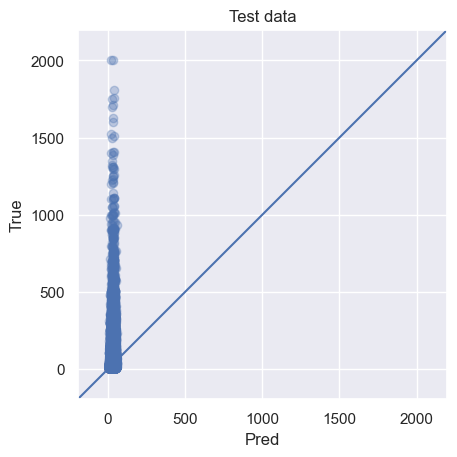

In [89]:
plt.scatter(y_test_pred, y_test, alpha=0.3)
plt.plot([y_min,y_max], [y_min,y_max])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(y_min, y_max)
plt.ylim(y_min, y_max)
plt.title('Test data')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

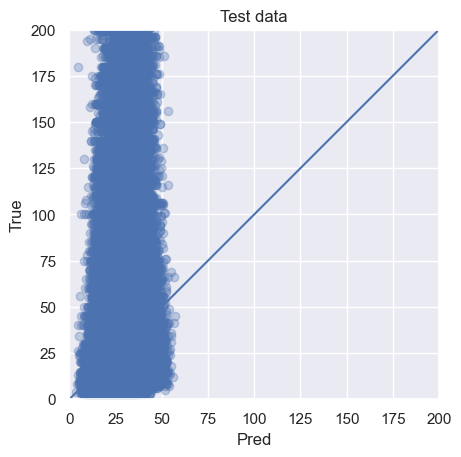

In [90]:
plt.scatter(y_test_pred, y_test, alpha=0.3)
plt.plot([y_min,y_max], [y_min,y_max])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 200) # <---
plt.ylim(0, 200) # <---
plt.title('Test data')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

In [91]:
mse = mean_squared_error(y_test, y_test_pred)
print('MSE, RMSE for test data:', mse, np.sqrt(mse))

MSE, RMSE for test data: 1421.0392897095069 37.69667478318886


パラメータ調整前： 1437.4049240873417 37.91312337551922

In [92]:
# モデルの評価
print("RMSLE for test data:", rmsle(np.expm1(y_test), np.expm1(y_test_pred)))

RMSLE for test data: 0.542020566786582


パラメータ調整前：0.5419677302884531

#### モデルの保存

In [93]:
from joblib import dump

tag = 'mercari'
model_file = 'ridge_{}.joblib'.format(tag)
dump(ridge, model_file)

['ridge_mercari.joblib']

In [94]:
stop_real = datetime.now()
execution_time_real = stop_real - start_real
print(execution_time_real)

0:21:52.610638
